<a href="https://colab.research.google.com/github/mingd00/Face-Recognition/blob/main/Notebooks/Xception(with_total_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, Add, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from tensorflow.keras.models import model_from_json
import pickle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/face_recognition/'

In [4]:
#Reading the dataset
dataset = pd.read_csv(path + 'data/face_emotion.csv')
dataset.head()

,emotion,pixels,Usage
0,0,195 184 176 178 179 182 184 181 177 171 164 17...,Training
1,0,87 85 80 75 74 76 76 75 73 73 74 76 80 82 86 8...,Training
2,0,154 153 205 179 180 174 158 99 123 135 172 203...,Training
3,0,208 219 226 213 211 178 86 95 100 103 104 104 ...,Training
4,0,61 56 50 46 43 39 36 33 31 30 29 28 26 24 23 2...,Training


<ipython-input-57-05bb5fba6baf>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = dataset.groupby('emotion', group_keys=False).apply(


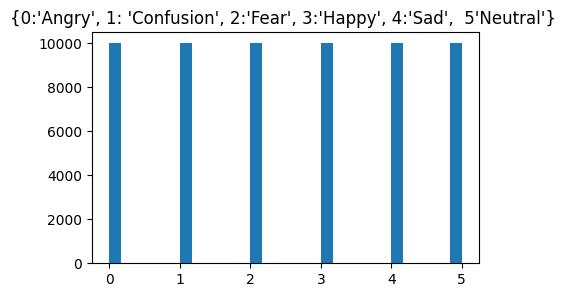

In [57]:
# 4000개씩 샘플링
final_df = dataset.groupby('emotion', group_keys=False).apply(
    lambda x: x.sample(10000, random_state=42) if len(x) >= 10000 else x
).reset_index(drop=True)

# 결과 확인
plt.figure(figsize=(5, 3))
plt.hist(final_df['emotion'], bins=30)
plt.title("{0:'Angry', 1: 'Confusion', 2:'Fear', 3:'Happy', 4:'Sad',  5'Neutral'} ")
plt.show()

In [58]:
# 1. 데이터프레임 섞기
df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. emotion 별로 데이터를 처리하기 위한 빈 리스트
train_list = []
val_list = []
test_list = []

# 3. emotion 별로 데이터 분리 및 비율에 따라 분할
for emotion, group in df.groupby('emotion'):
    # 3.1 6:4로 첫 번째 분리
    train, temp = train_test_split(group, test_size=0.4, random_state=42)
    # 3.2 남은 40% 데이터를 2:2로 나누기
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    # 3.3 결과를 각각 리스트에 저장
    train_list.append(train.assign(Usage='Training'))
    val_list.append(val.assign(Usage='Validation'))
    test_list.append(test.assign(Usage='Test'))

# 4. 각 리스트를 데이터프레임으로 결합
train_df = pd.concat(train_list)
val_df = pd.concat(val_list)
test_df = pd.concat(test_list)

# 5. 최종 데이터프레임 병합
final_df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

# 결과 확인
print(final_df['Usage'].value_counts())  # Training, Validation, Test 개수 확인
print(final_df['emotion'].value_counts())  # emotion별 데이터 분포 확인

Usage
Training      36000
Validation    12000
Test          12000
Name: count, dtype: int64
emotion
0    10000
1    10000
2    10000
3    10000
4    10000
5    10000
Name: count, dtype: int64


In [59]:
#Obtaining train data where usage is "Training"
train = final_df[final_df["Usage"] == "Training"]

#Obtaining test data where usage is "Validation"
val = final_df[final_df["Usage"] == "Validation"]

#Obtaining test data where usage is "Test"
test = final_df[final_df["Usage"] == "Test"]

#Converting " " separated pixel values to list
train.loc[:, 'pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep=' '))
val.loc[:, 'pixels'] = val['pixels'].apply(lambda image_px : np.fromstring(image_px, sep=' '))
test.loc[:, 'pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep=' '))

<ipython-input-59-98ba09dc29c1>:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  train.loc[:, 'pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep=' '))
<ipython-input-59-98ba09dc29c1>:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  val.loc[:, 'pixels'] = val['pixels'].apply(lambda image_px : np.fromstring(image_px, sep=' '))
<ipython-input-59-98ba09dc29c1>:13: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  test.loc[:, 'pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep=' '))


In [60]:
train.shape, val.shape, test.shape

((36000, 3), (12000, 3), (12000, 3))

In [61]:
# train, val, test에서 크기가 2304가 아닌 데이터 제거
train = train[train['pixels'].apply(lambda x: x.shape == (2304,))]
val = val[val['pixels'].apply(lambda x: x.shape == (2304,))]
test = test[test['pixels'].apply(lambda x: x.shape == (2304,))]

train.shape, val.shape, test.shape

((33207, 3), (11110, 3), (11060, 3))

In [62]:
shape_x = 48
shape_y = 48

X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_val = val.iloc[:, 1].values
y_val = val.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_val = np.vstack(X_val)
X_test = np.vstack(X_test)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_val = np.reshape(X_val, (X_val.shape[0],48,48,1))
y_val = np.reshape(y_val, (y_val.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_val and y_val is " + str(X_val.shape) +" and " + str(y_val.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (33207, 48, 48, 1) and (33207, 1) respectively.
Shape of X_val and y_val is (11110, 48, 48, 1) and (11110, 1) respectively.
Shape of X_test and y_test is (11060, 48, 48, 1) and (11060, 1) respectively.


In [63]:
# Change to float datatype
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

In [64]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  6
Output classes :  [0 1 2 3 4 5]


In [65]:
#Defining labels
def get_label(argument):
    labels = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad' , 4:'Surprise', 5:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

Text(0.5, 1.0, 'Ground Truth : Angry')

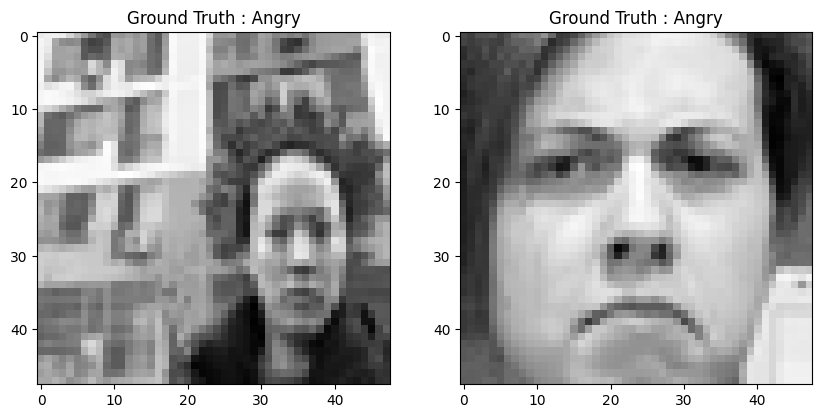

In [66]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[0].item()))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500].item()))))

In [24]:
def detect_face(frame):
    # 얼굴 탐지를 위해 OpenCV에서 제공하는 사전 학습된 Haar Cascade 분류기 모델 파일 경로 설정
    cascPath = path + 'model/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)  # 분류기 초기화

    # 입력된 프레임을 BGR 색상에서 회색조(Grayscale)로 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 다중 스케일의 얼굴을 탐지하기 위해 CascadeClassifier의 detectMultiScale 함수 사용
    detected_faces = faceCascade.detectMultiScale(
        gray,               # 회색조 이미지에서 얼굴 탐지
        scaleFactor=1.1,    # 이미지 크기를 10%씩 줄여가며 검색
        minNeighbors=6,     # 탐지된 영역 주변의 이웃 수를 설정 (값이 높을수록 더 정확한 탐지)
        minSize=(shape_x, shape_y),  # 탐지할 최소 얼굴 크기
        flags=cv2.CASCADE_SCALE_IMAGE  # 기본 이미지 크기에서만 검색
    )

    # 얼굴의 좌표를 저장할 리스트
    coord = []

    # 탐지된 얼굴 좌표를 반복하여 처리
    for x, y, w, h in detected_faces:
        if w > 100:  # 너비가 100 픽셀보다 큰 경우만 처리 (작은 얼굴은 무시)
            sub_img = frame[y:y+h, x:x+w]  # 얼굴 영역을 잘라내어 하위 이미지로 저장
            # cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1)  # (옵션) 얼굴에 사각형 표시
            coord.append([x, y, w, h])  # 얼굴의 좌표(x, y, 너비, 높이)를 coord 리스트에 추가

    # 회색조 이미지, 탐지된 얼굴 영역, 좌표를 반환
    return gray, detected_faces, coord

In [25]:
# 얼굴 특징 추출
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    # 입력된 데이터에서 회색조 이미지와 탐지된 얼굴 좌표 가져오기
    gray = faces[0]          # 회색조 이미지
    detected_face = faces[1] # 탐지된 얼굴 좌표

    # 결과로 반환할 얼굴 특징 리스트
    new_face = []

    # 탐지된 얼굴을 반복 처리
    for det in detected_face:
        x, y, w, h = det

        horizontal_offset = int(np.floor(offset_coefficients[0] * w))
        vertical_offset = int(np.floor(offset_coefficients[1] * h))

        # 추출할 얼굴 영역 설정
        extracted_face = gray[
            y + vertical_offset : y + h,
            x + horizontal_offset : x - horizontal_offset + w
        ]

        # 추출된 얼굴 이미지를 줌 조정 (설정된 크기로 스케일 변경)
        new_extracted_face = zoom(
            extracted_face,
            (shape_x / extracted_face.shape[0], shape_y / extracted_face.shape[1])  # 목표 크기로 조정
        )

        # 데이터를 float32 형식으로 변환
        new_extracted_face = new_extracted_face.astype(np.float32)

        # 이미지를 정규화 (최대값으로 나누어 0~1 사이 값으로 변환)
        new_extracted_face /= float(new_extracted_face.max())

        # 정규화된 얼굴 이미지를 결과 리스트에 추가
        new_face.append(new_extracted_face)

    # 정규화된 모든 얼굴 이미지를 반환
    return new_face

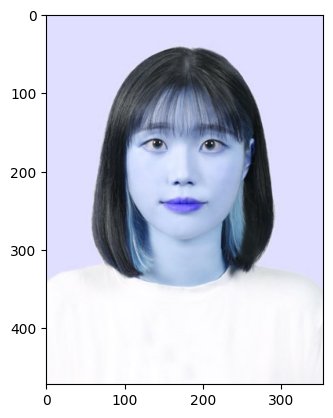

In [26]:
img = path + 'test_data/img.jpg'
img_face = cv2.imread(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_face)

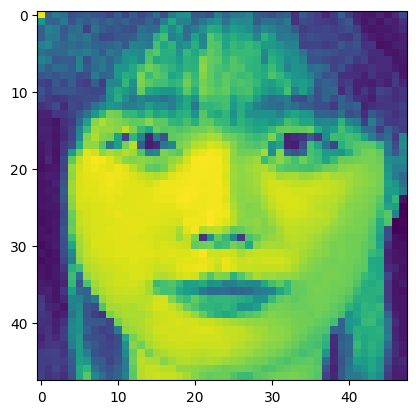

In [27]:
face = extract_face_features(detect_face(img_face))[0]
plt.imshow(face)

In [ ]:
def createModel():

    #Model Initialization
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

    #Flattening
    model.add(Flatten())

    #Adding fully connected layer
    model.add(Dense(512, activation='relu'))

    #Adding Output Layer
    model.add(Dense(6, activation='softmax'))

    return model

In [ ]:
# 모델 컴파일 및 학습
model = createModel()
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 설정
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(train_data, train_labels_one_hot, epochs = 50, validation_data=(test_data, test_labels_one_hot), callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1912 - loss: 1.8277 - val_accuracy: 0.2753 - val_loss: 1.7292
Epoch 2/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2726 - loss: 1.7139 - val_accuracy: 0.3078 - val_loss: 1.6714
Epoch 3/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3121 - loss: 1.6611 - val_accuracy: 0.3311 - val_loss: 1.6350
Epoch 4/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3434 - loss: 1.6194 - val_accuracy: 0.3476 - val_loss: 1.6030
Epoch 5/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3670 - loss: 1.5782 - val_accuracy: 0.3662 - val_loss: 1.5765
Epoch 6/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3924 - loss: 1.5381 - val_accuracy: 0.3751 - val_loss: 1.5608
Epoch 7/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4130 - loss: 1.5087 - val_accuracy: 0.3945 - val_loss: 1.5382
Epoch 8/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4121 - loss: 1.4976 - val_accuracy: 0.

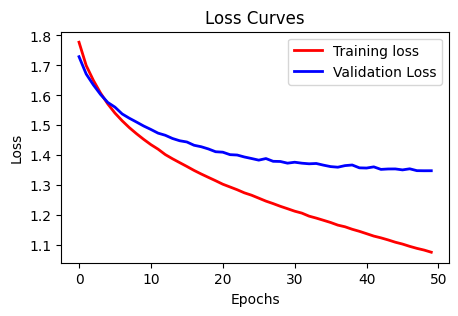

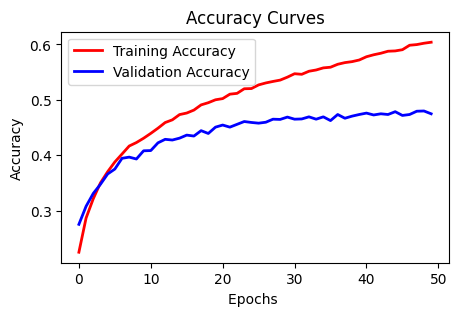

In [ ]:
# 손실 함수
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

# 정확도
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs ')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()

- Xception Model

In [67]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = Add()([x, residual])
        previous_block_activation = x

    return x

def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, previous_block_activation])
        previous_block_activation = x

    return x


def exit_flow(x, num_classes=6) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return x

In [68]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

xception_model = Model(inputs, outputs)

In [69]:
# 모델 컴파일 및 학습
xception_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 설정
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
]

history = xception_model.fit(train_data, train_labels_one_hot, epochs = 50, validation_data=(test_data, test_labels_one_hot), callbacks=callbacks)

Epoch 1/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 100s 59ms/step - accuracy: 0.1800 - loss: 1.7981 - val_accuracy: 0.1903 - val_loss: 1.7928
Epoch 2/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.2766 - loss: 1.7243 - val_accuracy: 0.1902 - val_loss: 1.7990
Epoch 3/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.3716 - loss: 1.6242 - val_accuracy: 0.1892 - val_loss: 1.8427
Epoch 4/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.5017 - loss: 1.4159 - val_accuracy: 0.1901 - val_loss: 2.0028
Epoch 5/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6596 - loss: 1.0690 - val_accuracy: 0.1803 - val_loss: 2.2399
Epoch 6/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8153 - loss: 0.6742 - val_accuracy: 0.1816 - val_loss: 2.6803


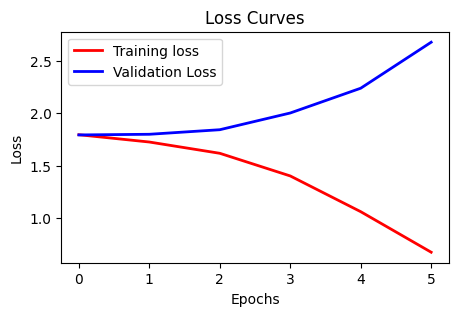

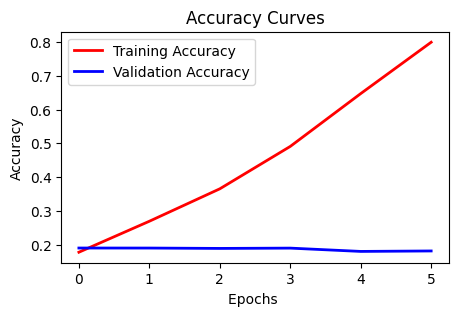

In [70]:
# 손실 함수
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

# 정확도
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs ')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()

In [71]:
# 케라스로 저장 후 불러오기
xception_model.save("face_model.keras")
loaded_model = load_model("face_model.keras")

In [72]:
# 사진 데이터 예측
img = path + 'test_data/img.jpg'
img_face = cv2.imread(img)

for face in extract_face_features(detect_face(img_face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res = loaded_model.predict(to_predict)
    result_num = np.argmax(res)
    print(result_num)
    print(get_label(result_num))
    for i, prob in enumerate(res[0]):
      print(f"Class {i} ({get_label(i)}): {prob * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
3
Sad
Class 0 (Angry): 11.22%
Class 1 (Fear): 4.97%
Class 2 (Happy): 19.30%
Class 3 (Sad): 29.40%
Class 4 (Surprise): 18.71%
Class 5 (Neutral): 16.39%


In [73]:
# 영상 데이터 예측
import cv2
import time
from google.colab.patches import cv2_imshow  # Colab에서 이미지를 표시하기 위해 임포트

# 영상 파일 경로
video_path = path + 'test_data/video.mp4'  # 영상 파일 경로 지정

# 영상 파일 열기
video_capture = cv2.VideoCapture(video_path)

# 영상의 FPS 확인
fps = video_capture.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
frame_interval = int(fps)  # 초당 프레임 수로 1초마다 프레임 추출

# 현재 시간
frame_count = 0  # 프레임을 카운트하는 변수

while True:
    # 영상에서 프레임 읽기
    ret, frame = video_capture.read()

    # 프레임이 제대로 읽어졌는지 확인
    if not ret:
        print("영상에서 프레임을 읽을 수 없습니다.")
        break

    # 1초마다 프레임을 추출하여 표시
    if frame_count % frame_interval == 0:  # FPS 기준으로 1초마다
        # 프레임을 화면에 표시
        for face in extract_face_features(detect_face(frame)):
          to_predict = np.reshape(face.flatten(), (1,48,48,1))
          res = loaded_model.predict(to_predict)
          result_num = np.argmax(res)
          print(result_num)
          print(get_label(result_num))

        # 각 클래스에 대한 확률을 출력
        for i, prob in enumerate(res[0]):
            print(f"Class {i} ({get_label(i)}): {prob * 100:.2f}%")  # 확률을 백분율로 출력
        print(frame_count // frame_interval)

    # 프레임 카운트 증가
    frame_count += 1

# 모든 작업 완료 후 캡처 리소스 해제
video_capture.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3
Sad
Class 0 (Angry): 10.41%
Class 1 (Fear): 3.13%
Class 2 (Happy): 14.11%
Class 3 (Sad): 32.52%
Class 4 (Surprise): 21.95%
Class 5 (Neutral): 17.89%
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3
Sad
Class 0 (Angry): 9.44%
Class 1 (Fear): 3.28%
Class 2 (Happy): 13.98%
Class 3 (Sad): 36.97%
Class 4 (Surprise): 19.42%
Class 5 (Neutral): 16.92%
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3
Sad
Class 0 (Angry): 10.89%
Class 1 (Fear): 4.24%
Class 2 (Happy): 15.48%
Class 3 (Sad): 28.67%
Class 4 (Surprise): 23.98%
Class 5 (Neutral): 16.74%
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4
Surprise
Class 0 (Angry): 12.12%
Class 1 (Fear): 3.78%
Class 2 (Happy): 15.92%
Class 3 (Sad): 21.64%
Class 4 (Surprise): 25.53%
Class 5 (Neutral): 21.01%
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3
Sad
Class 0 (Angry): 10.95%
Class 1 (Fear): 4.05%
Class 2 (Happy): 15.40%
Class 3 (Sad): 33.42%
Class 4 (Surprise): 20.37%
Class 5 (Neutral): 15.82%
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3
S

In [ ]:
x